# Create a polynomial chaos for the Ishigami function

In this example, we create a polynomial chaos for the Ishigami function. We create a sparse polynomial with maximum total degree equal to 8. 

Let $a=7$ and $b=0.1$. We consider the function 

$$
g(X_1,X_2,X_3) = \sin(X_1)+a \sin (X_2)^2 + b X_3^4 \sin(X_1)
$$

for any $X_1,X_2,X_3\in[-\pi,\pi]$ 

We assume that the random variables $X_1,X_2,X_3$ are independent and have the uniform marginal distribution in the interval from $-\pi$ to $\pi$:

$$
X_1,X_2,X_3\sim \mathcal{U}(-\pi,\pi).
$$

## Analysis 

The expectation and the variance of $Y$ are 

$$
E(Y)  = \frac{a}{2}
$$

and 

$$
V(Y) = \frac{1}{2} +  \frac{a^2}{8} +  \frac{b^2 \pi^8}{18} +  \frac{b\pi^4}{5}.
$$

The Sobol' decomposition variances are

\begin{eqnarray*}
V_1     &=& \frac{1}{2} \left(1 + b\frac{\pi^4}{5} \right)^2 \\
V_2     &=& \frac{a^2}{8} \\
V_{1,3} &=& b^2 \pi^8 \frac{8}{225} \\
\end{eqnarray*}

and $V_3=V_{1,2} = V_{2,3}=V_{1,2,3} = 0$.

This leads to the following first order Sobol' indices:

$$
S_1 = \frac{V_1}{V(Y)}, \qquad S_2 = \frac{V_2}{V(Y)}, \qquad S_3 = 0,
$$

and the following total order indices:

$$
ST_1 = \frac{V_1+V_{1,3}}{V(Y)}, \qquad ST_2 = S_2, \qquad S_3 = \frac{V_{1,3}}{V(Y)}.
$$

The third variable $X_3$ has no effect at first order (because $X_3^4$ it is multiplied by $\sin(X_1)$), but has a total effet because of the interactions with $X_1$. On the other hand, the second variable $X_2$ has no interactions which implies that the first order indice is equal to the total order indice for this input variable.

## References

* Ishigami, T., & Homma, T. (1990, December). An importance quantification technique in uncertainty analysis for computer models. In Uncertainty Modeling and Analysis, 1990. Proceedings., First International Symposium on (pp. 398-403). IEEE.

* Sobol', I. M., & Levitan, Y. L. (1999). On the use of variance reducing multipliers in Monte Carlo computations of a global sensitivity index. Computer Physics Communications, 117(1), 52-61.

* Saltelli, A., Chan, K., & Scott, E. M. (Eds.). (2000). Sensitivity analysis (Vol. 134). New York: Wiley.

* Crestaux, T., Martinez, J.-M., Le Maitre, O., & Lafitte, O. (2007). Polynomial chaos expansion for uncertainties quantification and sensitivity analysis. SAMO 2007, http://samo2007.chem.elte.hu/lectures/Crestaux.pdf.

## Define the model

In [1]:
import openturns as ot
import numpy as np

Create the Ishigami test function.

In [2]:
ot.RandomGenerator.SetSeed(0)
formula = ['sin(X1) + 7. * sin(X2)^2 + 0.1 * X3^4 * sin(X1)']
input_names = ['X1', 'X2', 'X3']
g = ot.SymbolicFunction(input_names, formula)

Create the probabilistic model

In [3]:
inputDimension = 3
distributionList = [ot.Uniform(-np.pi, np.pi)] * inputDimension
distribution = ot.ComposedDistribution(distributionList)

## Draw the function

Create a training sample

In [4]:
N = 1000
inputSample = distribution.getSample(N)
outputSample = g(inputSample)

In [5]:
def plotXvsY(sampleX, sampleY, figsize=(15,3)):
    import pylab as pl
    import openturns.viewer
    dimX = sampleX.getDimension()
    inputdescr = sampleX.getDescription()
    fig = pl.figure(figsize=figsize)
    for i in range(dimX):
        ax = fig.add_subplot(1, dimX, i+1)
        graph = ot.Graph('', inputdescr[i], 'Y', True, '')
        cloud = ot.Cloud(sampleX[:,i],sampleY)
        graph.add(cloud)
        _ = ot.viewer.View(graph, figure=fig, axes=[ax])
    return None

plotXvsY(inputSample, outputSample)

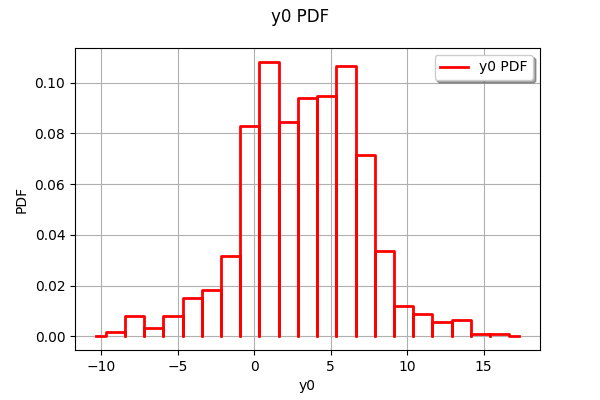

In [6]:
ot.HistogramFactory().build(outputSample).drawPDF()

We see that the distribution of the output has two modes. 

## Create the polynomial chaos model

Create a training sample

In [7]:
N = 100 
inputTrain = distribution.getSample(N)
outputTrain = g(inputTrain)

Create the chaos.

We could use only the input and output training samples: in this case, the distribution of the input sample is computed by selecting the best distribution that fits the data. 

In [8]:
chaosalgo = ot.FunctionalChaosAlgorithm(inputTrain, outputTrain)

Since the input distribution is known in our particular case, we instead create the multivariate basis from the distribution.

In [9]:
multivariateBasis = ot.OrthogonalProductPolynomialFactory(distributionList)
selectionAlgorithm = ot.LeastSquaresMetaModelSelectionFactory()
projectionStrategy = ot.LeastSquaresStrategy(inputTrain, outputTrain, selectionAlgorithm)
totalDegree = 8
enumfunc = multivariateBasis.getEnumerateFunction()
P = enumfunc.getStrataCumulatedCardinal(totalDegree)
adaptiveStrategy = ot.FixedStrategy(multivariateBasis, P)
chaosalgo = ot.FunctionalChaosAlgorithm(inputTrain, outputTrain, distribution, adaptiveStrategy, projectionStrategy)

In [10]:
chaosalgo.run()
result = chaosalgo.getResult()
metamodel = result.getMetaModel()

In order to validate the metamodel, we generate a test sample.

In [11]:
n_valid = 1000
inputTest = distribution.getSample(n_valid)
outputTest = g(inputTest)
val = ot.MetaModelValidation(inputTest, outputTest, metamodel)
Q2 = val.computePredictivityFactor()
Q2

0.9994752470145457

The Q2 is very close to 1: the metamodel is excellent.

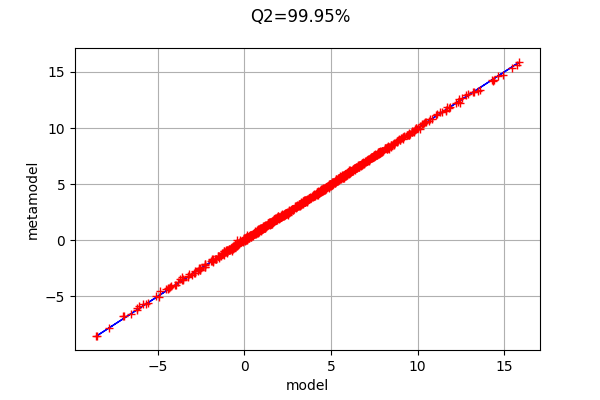

In [12]:
graph = val.drawValidation()
graph.setLegends([""])
graph.setTitle("Q2=%.2f%%" % (Q2*100))
graph

The metamodel has a good predictivity, since the points are almost on the first diagonal.

## Compute and print Sobol' indices

In [13]:
chaosSI = ot.FunctionalChaosSobolIndices(result) 
print(chaosSI.summary())

 input dimension: 3
 output dimension: 1
 basis size: 21
 mean: [3.51725]
 std-dev: [3.70631]
------------------------------------------------------------
Index   | Multi-indice                  | Part of variance  
------------------------------------------------------------
      6 | [0,4,0]                       | 0.273917
      1 | [1,0,0]                       | 0.191725
      5 | [1,0,2]                       | 0.135136
     11 | [0,6,0]                       | 0.134366
      4 | [3,0,0]                       | 0.120877
      9 | [3,0,2]                       | 0.0850971
      3 | [0,2,0]                       | 0.0253318
     10 | [1,0,4]                       | 0.0122786
------------------------------------------------------------


------------------------------------------------------------
Component | Sobol index            | Sobol total index      
------------------------------------------------------------
        0 | 0.315184               | 0.557148              
      

We notice the a coefficient with marginal degree equal to 6 has a significant impact on the output variance. Hence, we cannot get a satisfactory polynomial chaos with total degree less that 6. 

Draw Sobol' indices

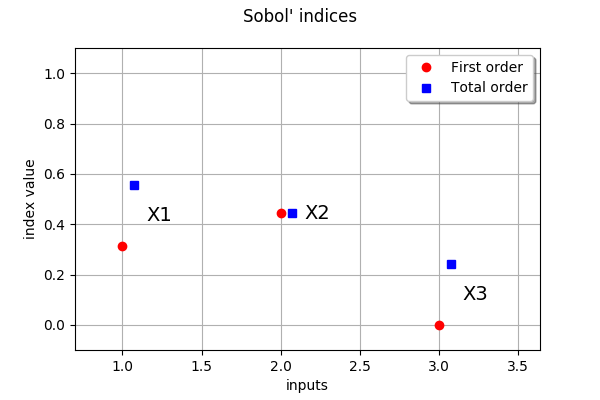

In [14]:
dim_input = distribution.getDimension()
first_order = [chaosSI.getSobolIndex(i) for i in range(dim_input)]
total_order = [chaosSI.getSobolTotalIndex(i) for i in range(dim_input)]
input_names = g.getInputDescription()
ot.SobolIndicesAlgorithm.DrawSobolIndices(input_names, first_order, total_order)

The variable which has the largest impact on the output is, taking interactions into account, X1. 

We see that X1 has interactions with other variables, since the first order indice is less than the total order indice.

At first order, X3 has no interactions with other variables since its first order indice is close to zero.

## Computing the accuracy

The interesting point with the Ishigami function is that the exact Sobol' indices are known. We can use that property in order to compute the absolute error on the Sobol' indices for the polynomial chaos. 

The following function computes the exact mean, variance and Sobol' indices for this function. 

In [15]:
def ishigamiSA(a,b):
    '''Exact sensitivity indices of the Ishigami function for given a and b.'''
    var = 1.0/2 + a**2/8 + b*np.pi**4/5 + b**2*np.pi**8/18
    S1 = (1.0/2 + b*np.pi**4/5+b**2*np.pi**8/50)/var
    S2 = (a**2/8)/var
    S3 = 0
    S13 = b**2*np.pi**8/2*(1.0/9-1.0/25)/var
    exact = {
            'expectation' : a/2, 
            'variance' : var,
            'S1' : (1.0/2 + b*np.pi**4/5+b**2*np.pi**8.0/50)/var,
            'S2' : (a**2/8)/var, 
            'S3' : 0,
            'S12' : 0,
            'S23' : 0,
            'S13' : S13,
            'S123' : 0,
            'ST1' : S1 + S13,
            'ST2' : S2,
            'ST3' : S3 + S13
            }
    return exact

In [16]:
a = 7.
b = 0.1
exact = ishigamiSA(a,b)
exact

{'expectation': 3.5,
 'variance': 13.844587940719254,
 'S1': 0.31390519114781146,
 'S2': 0.4424111447900409,
 'S3': 0,
 'S12': 0,
 'S23': 0,
 'S13': 0.2436836640621477,
 'S123': 0,
 'ST1': 0.5575888552099592,
 'ST2': 0.4424111447900409,
 'ST3': 0.2436836640621477}

To make the comparisons simpler, we gather the results into a list. 

In [17]:
S_exact = [exact["S1"],exact["S2"],exact["S3"]]
ST_exact = [exact["ST1"],exact["ST2"],exact["ST3"]]

Then we perform a loop over the input dimension and compute the absolute error on the Sobol' indices. 

In [18]:
for i in range(inputDimension):
    absoluteErrorS = abs(first_order[i]-S_exact[i])
    absoluteErrorST = abs(total_order[i]-ST_exact[i])
    print("X%d, Abs.Err. on S=%.1e, Abs.Err. on ST=%.1e" % (i+1, absoluteErrorS,absoluteErrorST))

X1, Abs.Err. on S=1.3e-03, Abs.Err. on ST=4.4e-04
X2, Abs.Err. on S=4.1e-04, Abs.Err. on ST=4.8e-04
X3, Abs.Err. on S=4.8e-07, Abs.Err. on ST=1.7e-03


We see that the indices are correctly estimated with a low accuracy even if we have use only 100 function evaluations. This shows the good performance of the polynomial chaos in this case.